In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import keras

import random as rn

np.random.seed(42)
rn.seed(42)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)


from keras import backend as K

tf.set_random_seed(42)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

generate_data = False


x = np.load("data/x.npy")
y = np.load("data/y.npy")

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization

best_aucroc = 0

In [3]:
activations = ['relu', 'softmax' 'tanh']
dropouts = [0.6, 0.4, 0.5, 0.7, 0.8]
num_total_layers = [2, 3, 4]
losses = ['binary_crossentropy']
val_sizes = [0.33]
last_layer_sizes = [100]
last_layer_drop_sizes = [0.15, 0.10, 0.05]


# activations = ['tanh']
# dropouts = [0.93, 0.3, 0.99]
# num_total_layers = [4]
# losses = ['categorical_hinge']
# val_sizes = [0.4]
# last_layer_sizes = [20]
# last_layer_drop_sizes = [0.15]

In [4]:
def get_correct_split(test_size_input):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size_input, random_state=42)
    return x_train, x_test, y_train, y_test

In [5]:
def create_model(activation, dropout, num_total_layer, last_layer_size, last_layer_drop_size):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(len(x_train[0]),)))
    model.add(Dense(300))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
    
    num_layers_still_needed = num_total_layer - 2 # We manually create first and last
        
    step_size = int((300 - last_layer_size) / (num_layers_still_needed + 1))
        
    count = 300

    
    for i in range(num_layers_still_needed):
        
        count -= step_size

        model.add(Dense(count))
        model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(dropout))

    model.add(Dense(last_layer_size))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(last_layer_drop_size))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [6]:
# model.summary()

In [7]:
from keras.callbacks import Callback

class Stat_Collector (Callback):
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

        self.aucrocs_train = []
        self.aucrocs_val = []

    def on_epoch_end(self, batch, logs=None):
        # Make aucroc prediction for training data
        y_pred_train = self.model.predict(x_train)
        y_pred_train = y_pred_train.flatten()
        self.aucrocs_train.append(roc_auc_score(y_train, y_pred_train))
        
        
        # Make aucroc prediction for validation data
        y_pred_val = self.model.predict(x_test)
        y_pred_val = y_pred_val.flatten()
        self.aucrocs_val.append(roc_auc_score(y_test, y_pred_val))

In [8]:
def train_model(model, activation, dropout, num_total_layer, loss, val_size, last_layer_size, last_layer_drop_size, x_train, y_train, x_test, y_test):
    stat_collect = Stat_Collector(x_train, y_train, x_test, y_test)

    model.compile(loss=loss,optimizer='adam', metrics=['accuracy'])

    fit = model.fit(x_train, y_train, batch_size=32, nb_epoch=30, verbose=1, callbacks = [stat_collect])

    import matplotlib.pyplot as plt

    num_epoch = len(stat_collect.aucrocs_val)

    # Plot training & validation accuracy values
    plt.plot([x + 1 for x in range(num_epoch)], stat_collect.aucrocs_train, label="Train AUCROC")
    plt.plot([x + 1 for x in range(num_epoch)], stat_collect.aucrocs_val, label="Test AUCROC")

    plt.xlabel('Test AUCROC maximized at epoch = {} with AUCROC = {}'.format(np.argmax(stat_collect.aucrocs_val) + 1, stat_collect.aucrocs_val[np.argmax(stat_collect.aucrocs_val)]))
    plt.ylabel('AUCROC')
    plt.title('Epochs vs. AUCROC')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig("plots/activation:{}_dropout:{}_numlayer:{}_loss:{}_valsize:{}_lastlayersize:{}_lastlayerdrop:{}.png".format(activation, dropout, num_total_layer, loss, val_size, last_layer_size, last_layer_drop_size))
    plt.show()
    global best_aucroc
    if best_aucroc < stat_collect.aucrocs_val[np.argmax(stat_collect.aucrocs_val)]:
        best_aucroc = stat_collect.aucrocs_val[np.argmax(stat_collect.aucrocs_val)]
        with open("plots/best_plot.txt", "a+") as f:
            f.write("plots/activation:{}_dropout:{}_numlayer:{}_loss:{}_valsize:{}_lastlayersize:{}_lastlayerdrop:{} \n Performance: {}\n".format(activation, dropout, num_total_layer, loss, val_size, last_layer_size, last_layer_drop_size, stat_collect.aucrocs_val[np.argmax(stat_collect.aucrocs_val)]))


relu 0.6 2 binary_crossentropy 0.33 100 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/2
43326/43326 [==============================] - 5s 111us/step - loss: 0.5187 - acc: 0.7496
Epoch 2/2
43326/43326 [==============================] - 4s 97us/step - loss: 0.4935 - acc: 0.7644


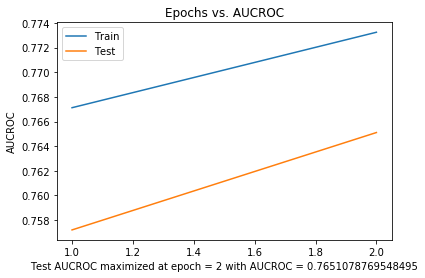

relu 0.6 2 binary_crossentropy 0.33 100 0.1


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/2
43326/43326 [==============================] - 5s 110us/step - loss: 0.5182 - acc: 0.7510
Epoch 2/2
43326/43326 [==============================] - 4s 94us/step - loss: 0.4924 - acc: 0.7652


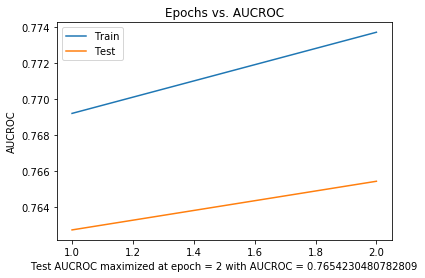

relu 0.6 2 binary_crossentropy 0.33 100 0.05


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/2
43326/43326 [==============================] - 5s 112us/step - loss: 0.5159 - acc: 0.7497
Epoch 2/2
43326/43326 [==============================] - 4s 95us/step - loss: 0.4922 - acc: 0.7651


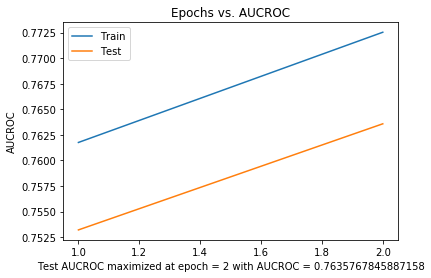

relu 0.6 3 binary_crossentropy 0.33 100 0.15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/2
43326/43326 [==============================] - 7s 151us/step - loss: 0.5315 - acc: 0.7406
Epoch 2/2
43326/43326 [==============================] - 5s 125us/step - loss: 0.4964 - acc: 0.7614


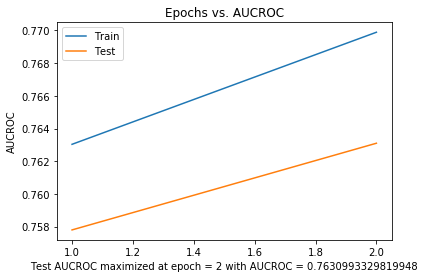

relu 0.6 3 binary_crossentropy 0.33 100 0.1


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/2
43326/43326 [==============================] - 7s 154us/step - loss: 0.5371 - acc: 0.7393
Epoch 2/2
16928/43326 [==========>...................] - ETA: 3s - loss: 0.4983 - acc: 0.7589

KeyboardInterrupt: 

In [9]:
for activation in activations:
    for dropout in dropouts:
        for num_total_layer in num_total_layers:
            for loss in losses:
                for val_size in val_sizes:
                    for last_layer_size in last_layer_sizes:
                        for last_layer_drop_size in last_layer_drop_sizes:
                            x_train, x_test, y_train, y_test = get_correct_split(val_size)
                            print(activation, dropout, num_total_layer, loss, val_size, last_layer_size, last_layer_drop_size)
                            model = create_model(activation, dropout, num_total_layer, last_layer_size, last_layer_drop_size)
                            train_model(model, activation, dropout, num_total_layer, loss, val_size, last_layer_size, last_layer_drop_size, x_train, y_train, x_test, y_test)
#                             model.summary()

In [ ]:
# def generate_csv(model, x_data, name):
#     ids = [i for i, _ in enumerate(x_data)]
#     ids = np.array(ids)
    
#     predictions = model.predict(x_data).flatten()
    
#     df = pd.DataFrame()
#     df['id'] = ids
#     df['target'] = predictions
#     df.to_csv(name + ".csv", index=False)

# #     print df.head()

# x_actual_test = np.load("data/x_test.npy")

# generate_csv(model, x_actual_test, "submissions/third_test")